# Predicting Obstetric Risk in Pregnant Diabetic Women
Final Project MAIS 202 Bootcamp



## Introduction

In this project, we study a dataset concerning pregnant women with diabetes. Diabetes is a known risk factor that can negatively affect the course of pregnancy. For each woman, we have access to 7 variables:

* `Age` : age in years

* `Systolic blood pressure` : systolic blood pressure in mmHg

* `Diastolic blood pressure`: diastolic blood pressure in mmHg

* `Blood glucose`: postprandial blood glucose level in mmol/L

* `Temperature`: body temperature in °C

* `Resting heart rate`: heart rate at rest

* `Risk`: obstetrical risk level (0: low, 1: medium, 2: high)

This project is divided into three parts:

1. An exploratory data analysis

2. The construction of a binary classifier to distinguish between pregnancies at risk and those that are not

3. The construction of a multiclass classifier to separate pregnancies into three categories: high risk, medium risk, and low risk

## Librairies

In [52]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import decomposition

plt.rc('font', **{'size': 12}) 
np.random.seed(19) 

## Load Data

We'll first work with training data in `data/donnees_entrainement.csv` :

In [53]:
df_train = pd.read_csv('donnees_entrainement.csv')
df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


We'll extract 2 arrays, `X_train` and `y_train`,  variables representing the observations and their labels :

In [54]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

print(X_train[:5])
print(y_train[:5])

[[ 21.   85.   55.    7.   36.2  84. ]
 [ 36.  145.  100.    6.9  39.5  73. ]
 [ 15.5 120.   75.    7.4  39.   74. ]
 [ 49.  135.  100.   15.9  37.8  72. ]
 [ 56.5 120.   90.   12.   36.9  74. ]]
[1 2 0 1 1]


# 1. Exploration of the Data

## Variables Distribution

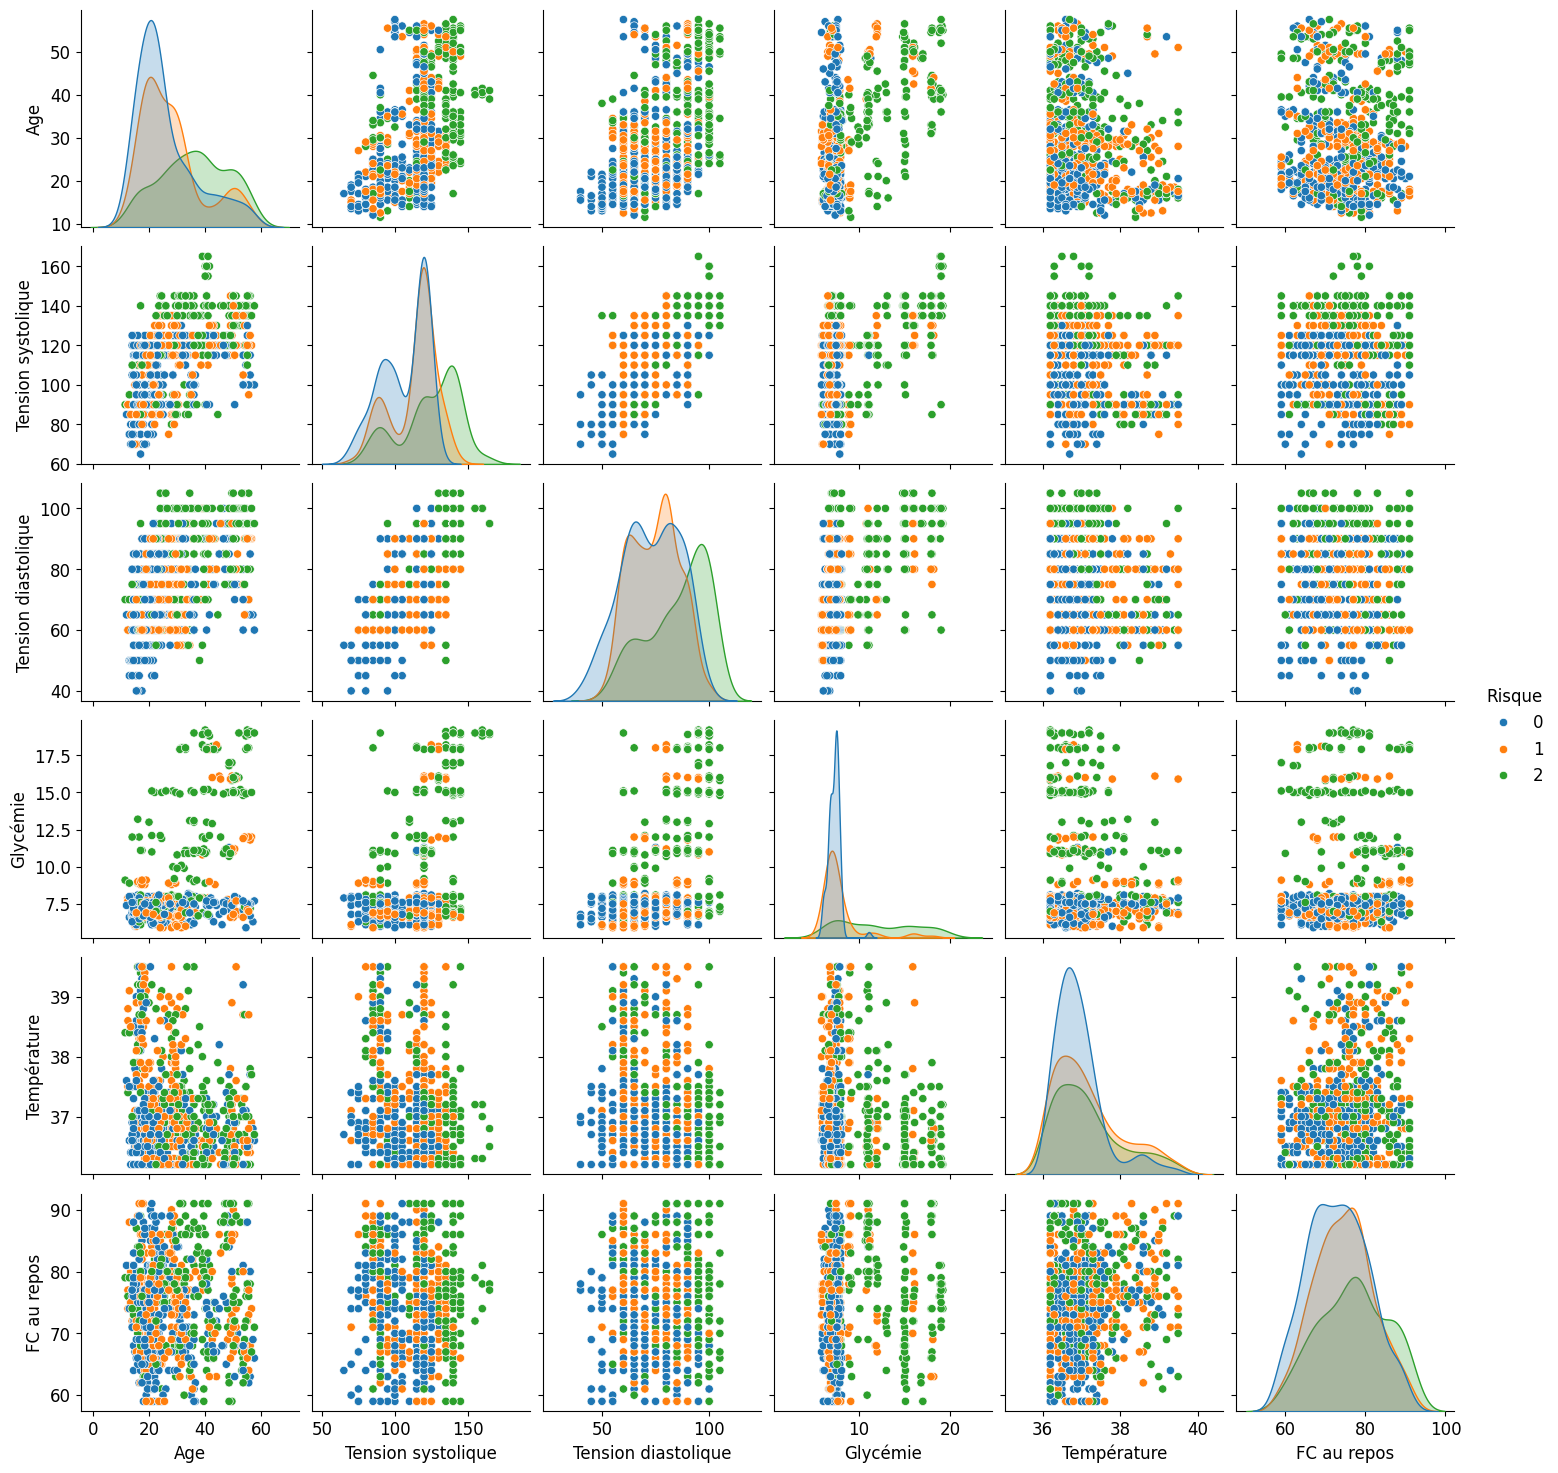

In [5]:
_ = sns.pairplot(df_train, hue="Risque",palette=["#1f77b4", "#ff7f0e", "#2ca02c"])

Use all of the 6 variables ?

Given the results obtained, not all variables appear to be equally correlated with the level of risk, which may lead to prediction difficulties by overloading the algorithms with non-significant data. 

## Dimension Reduction 

We will use Principal Component Analysis (PCA) on `X_train` to visualize the data in two dimensions.

Text(0.5, 1.0, 'Cumulative proportion of explained variance')

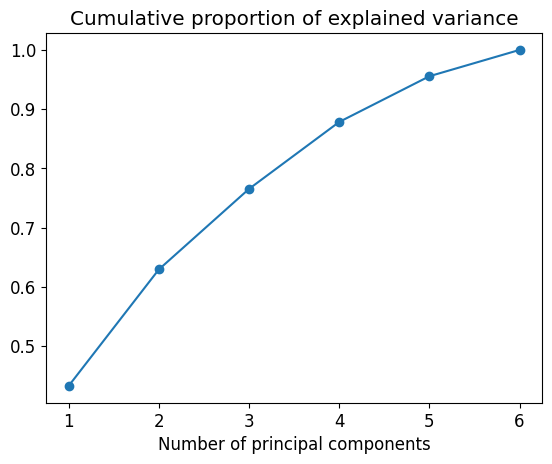

In [6]:
# We standardize our data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)

# Instantiation of a PCA object with 6 principal components
pca = decomposition.PCA(n_components=6)

# We now apply the standardized data to this PCA object
pca.fit(X_train_scaled)

np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 7), np.cumsum(pca.explained_variance_ratio_), marker='o')

plt.xlabel("Number of principal components")
plt.title("Cumulative proportion of explained variance")


Text(0, 0.5, 'PC 2')

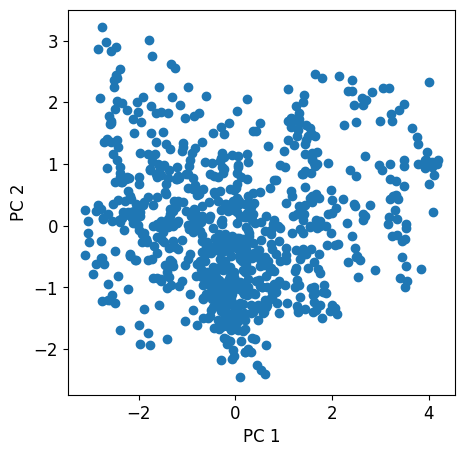

In [7]:
# We project onto the first two principal components
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_projected = pca.transform(X_train_scaled)

fig = plt.figure(figsize=(5, 5))

plt.scatter(X_train_projected[:, 0], X_train_projected[:, 1])

plt.xlabel("PC 1")
plt.ylabel("PC 2")

By keeping only the first two principal components, we capture less than 65% of the explained variance. This is acceptable, but the risk predictor will not be very accurate and will be less discriminative. It would be better to keep at least the first four components, which explain 90% of the variance.

Correlation Matrix of the variables 

Text(0.5, 1.0, 'Correlation between the 6 variables')

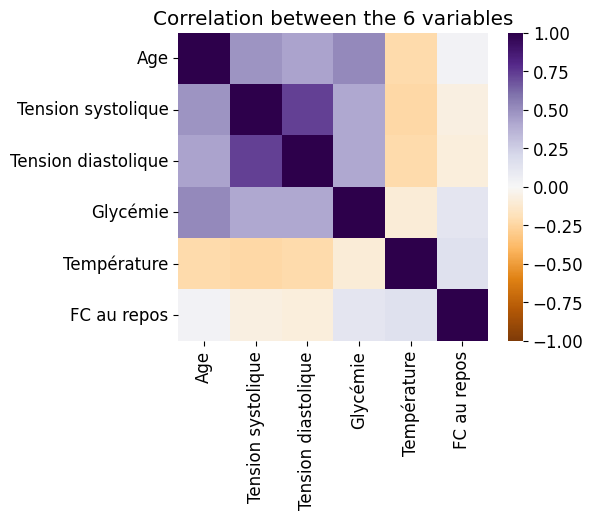

In [8]:
# Computing of correlation matrix 2 by 2 
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialise figure
plt.figure(figsize=(5, 4))

#  heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf 
            vmax=1, # borne sup 
            center= 0, # median value,
            cmap='PuOr', # colormap 
           )
# Titre
plt.title("Correlation between the 6 variables")

We observe that systolic and diastolic blood pressure are strongly correlated, which means they provide roughly the same information. Therefore, we could keep only one of the two and reduce the dimensionality by 1.
In general, we keep only the least correlated variables.

# 2. Binary classification: «risk» vs «no risk»

We will now transform the labels into binary labels by grouping medium and high obstetrical risks together. Labels `1` and `2` will be merged into a single label `1`.

In [9]:
 # Copy the original dataframe into a new dataframe
df_train_risk_vs_norisk = df_train.copy()

# Group labels 1 and 2 together
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque'] == 2, 1, df_train['Risque'])

# Extract the array of labels
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

# Extract the feature matrix
X_train = np.array(df_train_risk_vs_norisk.drop('Risque', axis=1))
y_train = y_train_risk_vs_norisk


In [10]:
df_train_risk_vs_norisk.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,1
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


## Choice of the the classification criteria



Quelle est l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [15]:
risk = (df_train_risk_vs_norisk['Risque']==1).sum()
no_risk = (df_train_risk_vs_norisk['Risque']==0).sum()
accuracy = max(risk, no_risk)/(risk+no_risk)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 60.50%


 We obtain an accuracy of around 60% for this model. There is a big purcentage of mistake.

__Balanced accuracy__ of a binary classification is given by :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$


In the context of the previous example, we obtain a BA of 50%, compared to 60% accuracy. This penalizes the model that predicts all observations as belonging to the majority class, a model that is far from optimal.

Therefore we will use this criteria in the rest for the rest of the project. 

## Nearest Neighbor

The nearest-neighbor algorithm assigns to an observation $\vec{x}$ the label of the point in the training set to which it is closest (by default, using the Euclidean distance).


__Training phase of this classificator__ : It will assign each data point the label of its closest neighbor, which is itself. The training phase therefore consists simply of memorizing the dataset.

It is better to standardize our data so that no feature dominates the others. Indeed, to select the nearest neighbors, we use a distance metric, which takes into account the different scales of the variables.
First, we need to find the optimal value of K (the number of neighbors).For each data point in the training set, and for a fixed K, we look at the labels of its K nearest neighbors and check whether the majority label matches the true label of the observation,for most observations.  

The previous example, where all observations were assigned to the majority class, corresponds to the case where we set K equal to the total number of data points minus 1 — in that case, all other points are neighbors. We obtained a balanced accuracy of 50%.
Therefore, we expect a balanced accuracy strictly greater than 50%.

When the metric is chosen appropriately, we can hope to find a value of K that yields a balanced accuracy close to 90%.


## K Nearest Neighbors


In [17]:
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score


Kneigh = neighbors.KNeighborsClassifier(n_neighbors=1) 
Kneigh.fit(X_train_scaled, y_train_risk_vs_norisk)
y_train_pred = Kneigh.predict(X_train_scaled)
balanced_accuracy_score(y_train_risk_vs_norisk, y_train_pred)

np.float64(1.0)

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [i for i in range (1, 100)]} #pour trouver le nombre optimal de voisins

Kneigh_cv = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, scoring='balanced_accuracy', cv=10, n_jobs=-1)
Kneigh_cv.fit(X_train_scaled, y_train_risk_vs_norisk)
Kneigh_cv.best_params_, Kneigh_cv.best_score_ 


({'n_neighbors': 8}, np.float64(0.7416049484309852))

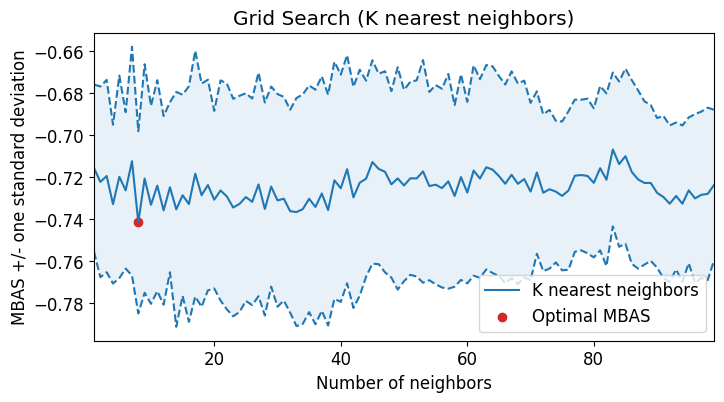

In [20]:
# Define the grid of values for the n_neighbors hyperparameter
nb_voisins = np.array([i for i in range(1, 100)])

# Initialize the plot frame
plt.figure(figsize=(8, 4))

mbas = -Kneigh_cv.cv_results_['mean_test_score']   # mean balanced accuracy score
std_error = Kneigh_cv.cv_results_['std_test_score']

# Plot the scores without a logarithmic scale on the x-axis:
plt.plot(nb_voisins, mbas, label="K nearest neighbors", color='tab:blue')  
# why plot RMSE and not balanced accuracy?

plt.plot(nb_voisins, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(nb_voisins, mbas - std_error, color='tab:blue', linestyle='dashed')

# Fill the area between the curves representing one standard deviation
plt.fill_between(
    nb_voisins, 
    (mbas + std_error), 
    (mbas - std_error),
    alpha=0.1  # controls transparency
)

# Plot the best score
plt.scatter(
    Kneigh_cv.best_params_['n_neighbors'], 
    -Kneigh_cv.best_score_,
    color='tab:red', 
    label='Optimal MBAS'
)

# Formatting
plt.xlabel("Number of neighbors")
plt.ylabel("MBAS +/- one standard deviation")
plt.xlim([nb_voisins[0], nb_voisins[-1]])
plt.title("Grid Search (K nearest neighbors)")
plt.legend(loc='best')


## Logistic Regression


I chose L2 regularisation because it shrinks the weights smoothly without setting any of them exactly to zero.
Using L1 regularisation would perform feature selection by driving some coefficients to zero, which is not desirable here since we already performed dimensionality reduction using PCA.
Therefore, L2 is more consistent with the structure of our feature space and avoids redundant sparsity.

In [21]:
from sklearn import linear_model

param_grid = {'C' : [1.0, 1.5, 1.75, 2.0, 2.5, 5.0, 10] }

Logi_cv = GridSearchCV(linear_model.LogisticRegression(), param_grid, scoring='balanced_accuracy', cv=10, n_jobs=-1)
Logi_cv.fit(X_train_scaled, y_train)
Logi_cv.best_params_, Logi_cv.best_score_ 

# Optimal C (= 1/λ) is 2.5 for 66% precision

({'C': 2.5}, np.float64(0.6612467769365811))

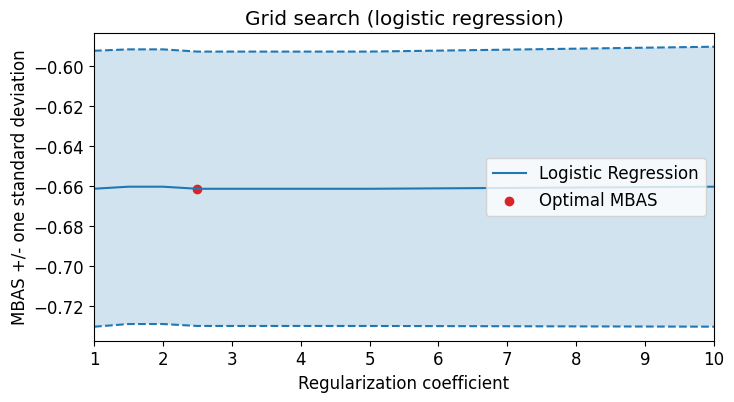

In [22]:
# Define the grid of values for the regularization coefficient hyperparameter
param_grid = [1.0, 1.5, 1.75, 2.0, 2.5, 5.0, 10]

# Initialize the plot frame
plt.figure(figsize=(8, 4))

mbas = -Logi_cv.cv_results_['mean_test_score']   # mean balanced accuracy score
std_error = Logi_cv.cv_results_['std_test_score']

# Plot the scores without a logarithmic scale on the x-axis:
plt.plot(param_grid, mbas, label="Logistic Regression", color='tab:blue')
# why plot RMSE and not balanced accuracy?

plt.plot(param_grid, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(param_grid, mbas - std_error, color='tab:blue', linestyle='dashed')

# Fill the area between the curves representing one standard deviation
plt.fill_between(
    param_grid,
    (mbas + std_error),
    (mbas - std_error),
    alpha=0.2   # controls transparency
)

# Plot the best score
plt.scatter(
    Logi_cv.best_params_['C'],
    -Logi_cv.best_score_,
    color='tab:red',
    label='Optimal MBAS'
)

# Formatting
plt.xlabel("Regularization coefficient")
plt.ylabel("MBAS +/- one standard deviation")
plt.xlim([param_grid[0], param_grid[-1]])
plt.title("Grid search (logistic regression)")
plt.legend(loc='best')


We observe that the L2 regularisation has almost no impact on the performance of the logistic regression model.
This behaviour is expected when the dataset is not very noisy, has a limited number of features, and does not show signs of overfitting.
In such cases, the optimisation is dominated by the log-likelihood term and the L2 penalty only induces a very small change in the weights, which explains why the balanced accuracy remains almost constant across different values of C.

## Non Linear Model

In [23]:
# Version allowing us to test different parameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {
    'n_estimators': [5*i for i in range(1, 22)],
    'max_depth': [None, 5],
    'min_samples_leaf': [1, 2]
}
# number of trees in the model; the lower value corresponds to the default value
# used in older Python versions, and the upper value is close to the one currently
# used (100). These are reasonable standard values in terms of model complexity.
# The other values are typical default values for these parameters.

# Initialize the decision tree model
tree_model = RandomForestClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param,
    cv=5,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

grid_search.fit(X_train_scaled, y_train_risk_vs_norisk)
grid_search.best_params_, grid_search.best_score_

# When the number of trees is the only parameter being tuned, we observe a large variability in the optimal number of trees found.
# If we search between 10 and 140 or between 10 and 130, the optimal value is not the same at all — however, the accuracy remains unchanged, which is what matters most.

# For 10 ≤ n_estimators ≤ 110, the optimal number of trees is 110, with an accuracy of 0.80.
# For 10 ≤ n_estimators ≤ 100, the optimal number is 60, with an accuracy of 0.80.

# Therefore, it is better to choose the smallest number of trees to reduce computation time, since performance is the same.
# When increasing model complexity by tuning additional parameters, the computation time becomes significantly longer — which is expected — but the accuracy remains identical.
# Thus, in the following steps, it makes sense to vary only the parameter n_estimators, which is the one that influences accuracy the most.

({'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 60},
 np.float64(0.7998795716740303))

In [34]:
#Model used from now
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,21)]} 


# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_scaled, y_train_risk_vs_norisk)
meilleurs_parametres = grid_search.best_params_ # we keep hyperparameters for final binary classificator 
grid_search.best_params_ , grid_search.best_score_

({'n_estimators': 30}, np.float64(0.80563686385207))

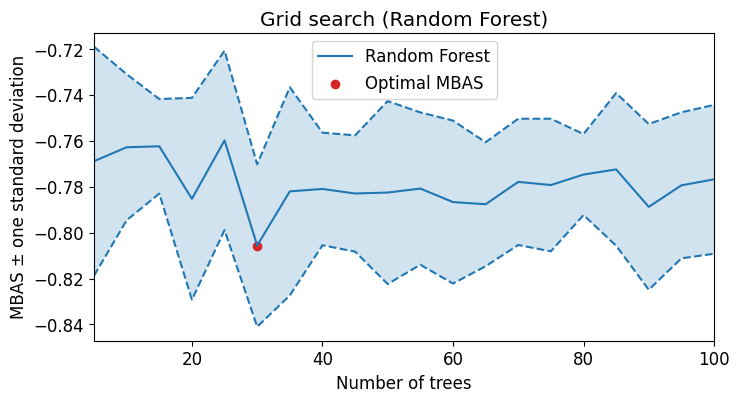

In [35]:
# Define the grid of values for the n_estimators hyperparameter, i.e. the number of trees
nb_trees = np.array([5*i for i in range(1, 21)])

# Initialize the plot frame
plt.figure(figsize=(8, 4))

mbas = -grid_search.cv_results_['mean_test_score']   # mean balanced accuracy score
std_error = grid_search.cv_results_['std_test_score']

# Plot the scores without a logarithmic scale on the x-axis:
plt.plot(nb_trees, mbas, label="Random Forest", color='tab:blue')
plt.plot(nb_trees, mbas + std_error, color='tab:blue', linestyle='dashed')
plt.plot(nb_trees, mbas - std_error, color='tab:blue', linestyle='dashed')

# Fill the area between the curves representing one standard deviation
plt.fill_between(
    nb_trees,
    (mbas + std_error),
    (mbas - std_error),
    alpha=0.2     # controls transparency
)

# Plot the best score
plt.scatter(
    grid_search.best_params_['n_estimators'],
    -grid_search.best_score_,
    color='tab:red',
    label='Optimal MBAS'
)

# Formatting
plt.xlabel("Number of trees")
plt.ylabel("MBAS ± one standard deviation")
plt.xlim([nb_trees[0], nb_trees[-1]])
plt.title("Grid search (Random Forest)")
plt.legend(loc='best')

# When varying only the number of trees between 10 and 110, we find an optimal parameter of nb_trees = 80. Visually, it clearly appears as the global minimum of the RMSE curve.

# However, we see that the curve tends to decrease again for the highest values; it is not impossible that by slightly increasing the number of trees in the simulation, we might obtain a noticeably different value.

## Classification after dimension reduction
what is the impact on accuracy ? 

In [36]:
# We would like to retain 95% of the explained variance while reducing the dimensionality as much as possible. Choosing to eliminate one principal component makes it reasonably possible to achieve this objective.
pca.fit(X_train_scaled)
X_train_projected = pca.transform(X_train_scaled)

__Once again, we use a grid search to optimize the performance of this algorithm, but trained on this new matrix.__

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# n_estimators = number of trees in the model; the lower value corresponds
# to the default value used in older Python versions, and the upper value
# is close to the one currently used (~100). These are reasonable standard
# values in terms of model complexity.
param = {'n_estimators': [5*i for i in range(1, 21)]}

# Initialize the decision tree model
tree_model = RandomForestClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param,
    cv=5,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

grid_search.fit(X_train_projected, y_train_risk_vs_norisk)
grid_search.best_params_, grid_search.best_score_



({'n_estimators': 55}, np.float64(0.6620180310096547))

Instead of using 30 trees in the model for an accuracy of 80%, we would need 55 trees to achieve an accuracy of 66%. The model with dimensionality reduction is more complex and less accurate. There is no benefit in using it. This is consistent with the fact that in random forests, variables are already randomly reduced at each node. The data are already heavily compressed this way, which also reduces computation time. Performing an additional dimensionality reduction in this case results in a real loss of information, especially when the variables are already weakly correlated.

In [38]:
grid_search.fit(X_train_scaled, y_train_risk_vs_norisk)
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 30}, np.float64(0.7936617881688758))

## Final Classificator


Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

In [39]:
dic = { Kneigh_cv.best_score_ : "k closest Neighbors", Logi_cv.best_score_ : "Logistic Regression", grid_search.best_score_ : "Random forests, non linear algo"}
print(f'Best performance is given by: {dic[max(dic)]}')

Best performance is given by: Random forests, non linear algo


In [40]:
final_binary_classifier = RandomForestClassifier(n_estimators= meilleurs_parametres['n_estimators'])
final_binary_classifier.fit(X_train_scaled, y_train_risk_vs_norisk)


RandomForestClassifier(n_estimators=30)

__Load Test Data `data/donnees_reservees.csv`__

In [41]:
df_test = pd.read_csv("donnees_reservees.csv")
df_test['Risque'] = np.where(df_test['Risque']==2, 1, df_test['Risque'])
df_test.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,20.5,120.0,70.0,6.6,36.7,71.0,0
1,50.5,130.0,100.0,15.9,36.3,72.0,1
2,23.0,120.0,90.0,7.5,37.0,64.0,0
3,17.5,120.0,75.0,7.2,36.2,65.0,0
4,23.5,125.0,85.0,8.1,36.7,64.0,0


We use `final_binary_classifier` to predict the labels of the observations in this dataset. (Don’t forget to apply any necessary data transformations.)

In [42]:
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int')

X_test_scaled = std_scale.transform(X_test)

prediction = final_binary_classifier.predict(X_test_scaled)

__Compare the balanced accuracy on the test set with the one obtained through cross-validation during model selection.__

In [ ]:
from sklearn.metrics import balanced_accuracy_score
score = balanced_accuracy_score(prediction, y_test)
print(score)

# Here we obtain an accuracy of 84% on the test data, compared to 80% on the training data.
# Our model learns well.

0.8416666666666667


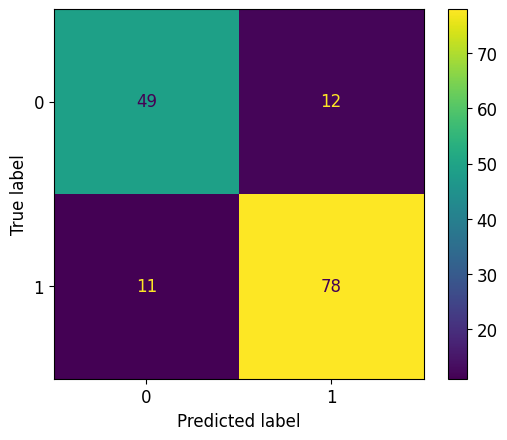

In [44]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, prediction)).plot()


The precision matrix shows that the model performs quite well in detecting high-risk pregnancies. Regarding the prediction of pregnancies that are not at risk, the model remains effective, although slightly less so than for predicting the presence of risk. The proportion of high-risk pregnancies predicted as not at risk is quite low, which is encouraging, since this is the worst-case scenario and the one we want to avoid at all costs. Indeed, such errors could affect the well-being and mental health of the women concerned, so the fact that this prediction is not entirely eliminated remains problematic.

Such a classifier could be used to determine which women should be referred for closer medical monitoring of their pregnancy, especially in the context described at the beginning of the project—namely, a disadvantaged region of the world. However, if such a classifier were to be used, it would be essential to inform the women that the prediction is not 100% reliable and to advise them to consult a doctor promptly if they experience any symptoms.

Finally, a limitation of this classifier is its binary nature. Its use would place women with moderately risky pregnancies and those with highly risky pregnancies on the same level in terms of referral to specialized medical care. This may not be as necessary or urgent for pregnancies that present only a moderate level of risk.

# 3. Classification multi-class

Non-linear algorithms such as random forests and multilayer perceptrons can be directly used to train a multiclass classifier, unlike logistic regression and the k-nearest neighbors algorithm.

In [46]:
y_train = np.array(df_train['Risque'], dtype='int')


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param = {'n_estimators': [5*i for i in range(1,22)], 'min_samples_leaf': [1, 2, 3, 4, 5]} 

# initialise modele arbre decision
tree_model = RandomForestClassifier()
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=param, 
                           cv=5, 
                           n_jobs=-1, 
                           scoring='balanced_accuracy')

grid_search.fit(X_train_scaled, y_train)
grid_search.best_params_ , grid_search.best_score_ 
final_best_param = grid_search.best_params_
print(final_best_param)


{'min_samples_leaf': 1, 'n_estimators': 55}


In [51]:
final_multiclass_classifier = RandomForestClassifier(n_estimators=final_best_param['n_estimators'], min_samples_leaf=final_best_param['min_samples_leaf'])
final_multiclass_classifier.fit(X_train_scaled, y_train)

df_test = pd.read_csv("donnees_reservees.csv")
X_test = np.array(df_test.drop('Risque', axis=1))
y_test = np.array(df_test['Risque'], dtype='int') # we keep 3 classes for labels 

X_test_scaled = std_scale.transform(X_test)

final_prediction = final_multiclass_classifier.predict(X_test_scaled)

from sklearn.metrics import balanced_accuracy_score
score = balanced_accuracy_score(final_prediction, y_test)
print(score)

0.8001584606677986


Conclusion: we obtain a balanced accuracy of around 80% for predicting pregnancy risk across three classes, which is satisfactory.

In [88]:
import joblib

# À lancer une fois après l'entraînement
joblib.dump(final_multiclass_classifier, "pregnancy_risk_model.joblib")
joblib.dump(std_scale, "pregnancy_scaler.joblib")


['pregnancy_scaler.joblib']